# IE 582 - HW4 - Kürşat Gürsoy

#### Task:
Suggest two alternative bag-level representations for the given multiple instance learning problem.
Based on the proposed bag-level representations for Musk1 dataset, evaluate at least two reasonable
classifiers (of your choice). The example representation is very simple and introduced for illustration
purposes. Please do not consider it as a valid alternative. You are expected to justify your bag-level
representation approach. This may be achieved by some descriptive analysis you perform (to motivate
your approaches). You can benefit from the literature as long as you provide your references
accordingly. Please note that if the proposed representation approach has certain parameters, these
parameters are also part of your algorithm. Hence, representation parameters (if there is any) should
also be tuned together with the parameters of your proposed approach. Specify the best set of parameter
combination for the proposed representations and your classifier. Use the accuracy based on 10-fold
cross-validation on the training data as your primary performance metric in your evaluations.

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import os
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics.pairwise as smp
from sklearn.datasets import make_swiss_roll 
from sklearn.manifold import MDS 
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy import spatial 
from math import comb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, f1_score
import time
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading data and renaming columns
data = pd.read_csv(r'C:\Users\IKG\Desktop\HW4_Files\Musk1.csv', header=None)
data.columns =["f"+str(i) for i in range(-1, 167)]
data.rename(columns={'f-1':'MuskClass', 'f0':'BagID' }, inplace = True)
data

,MuskClass,BagID,f1,f2,f3,f4,f5,f6,f7,f8,...,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
2,1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
3,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
4,1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0,92,49,-199,-161,29,-95,-86,-48,2,...,-220,-246,-209,33,152,134,47,-43,-15,-10
472,0,92,38,-123,-139,30,-117,-88,214,-13,...,-236,-226,-210,20,55,119,79,-28,4,74
473,0,92,43,-102,-20,-101,-116,200,-166,66,...,114,32,136,-15,143,121,55,-37,-19,-36
474,0,92,39,-58,27,31,-117,-92,85,21,...,-228,-232,-206,13,45,116,79,-28,3,74


In [3]:
# Checked how many of single instances are judged to be Musks(1) and non-Musks(0)
data.iloc[:,0].value_counts() 

0    269
1    207
Name: MuskClass, dtype: int64

In [4]:
# Checked how many of bags are judged to be Musks and non-Musks
df = pd.DataFrame(data.iloc[:,0:2])
df.drop_duplicates(keep = 'first', inplace = True)
df = df.reset_index(drop=True)
df['MuskClass'].value_counts() 

1    47
0    45
Name: MuskClass, dtype: int64

In [5]:
# Created a dataframe that holds the number of instances exist for each bag
bag_valuecounts = data.iloc[:,1].value_counts().sort_index()
bag_valuecounts = pd.DataFrame(bag_valuecounts)
bag_valuecounts.rename(columns={'BagID': 'Counts'}, inplace = True)

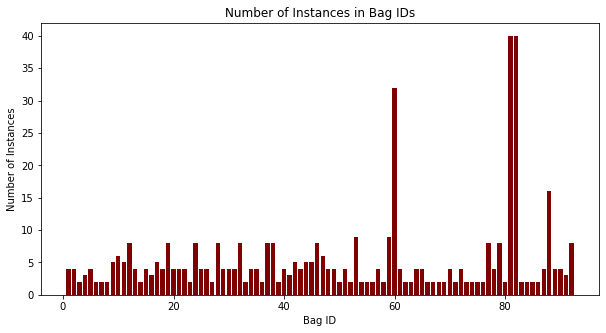

In [6]:
# Created a histogram demonstrating the number of instances for each bag(in this example, molecule is the bag)
fig = plt.figure(figsize = (10, 5))
plt.bar(bag_valuecounts.index, bag_valuecounts.iloc[:,0], color ='maroon')
plt.xlabel("Bag ID")
plt.ylabel("Number of Instances")
plt.title("Number of Instances in Bag IDs")
plt.show()

Two bag-level representations are created for this example and tested with 3 different algorithms, which are Logistic Lasso Regression(l1 penalty), Logistic Ridge Regression(l2 penalty) and Random Forest Classifier. Then, accuracy based on 10-fold Cross-Validation on the training datasets is used as the performance metric.

The bag-level representations will be named as 'First Option for Dataset' and 'Second Option for Dataset'. Datasets will be mentioned with the approaches behind them in the data preparation processes.

## First Option for Dataset

As the first option, since most of the bags do not include high number of instances(less than 10, can be seen in above figure),  an instance which is closest to its bags' mean value will be taken from each bag.

In [7]:
# First, data holding the mean of each bags'instances is created. 
data_mean = data.groupby("BagID").mean()
data_mean = data_mean.reset_index()

In [8]:
# Created data_opt1, which is holding instances which are closest to their bags' mean value.
data_opt1=[]
for k in range(1,data_mean.shape[0]+1):
    locals()["dst"+str(k)] = euclidean_distances(data[data['BagID']==k].iloc[:,2:], data_mean[data_mean['BagID']==k].iloc[:,2:])
    locals()["dst"+str(k)] = pd.DataFrame(locals()["dst"+str(k)])
    locals()["dst"+str(k)] = locals()["dst"+str(k)].sort_values(by=0)
    data_opt1.append(data[data['BagID']==k].reset_index().iloc[(locals()["dst"+str(k)].index[0]),:])
data_opt1=pd.DataFrame(data_opt1).drop(['index'], axis=1).reset_index(drop=True)

In [9]:
# Now we have the instances which are closest to the mean of their corresponding bag. (for each bag) 
data_opt1 

,MuskClass,BagID,f1,f2,f3,f4,f5,f6,f7,f8,...,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
1,1,2,42,-199,-102,-65,-117,55,23,-94,...,-238,-300,61,51,127,144,42,-30,14,25
2,1,3,40,-173,-142,13,-116,-7,50,-171,...,-236,-53,20,38,88,133,66,-28,13,58
3,1,4,41,-95,-61,-75,-117,15,30,-164,...,-241,-78,-132,-54,-32,31,49,-37,7,32
4,1,5,85,-158,-63,-74,-117,18,5,-114,...,-235,-63,-113,3,211,197,46,-36,-10,-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0,88,-7,-196,-147,-10,-117,-154,61,25,...,-241,-258,-209,-123,-17,24,125,5,30,121
88,0,89,19,69,36,39,-112,87,6,-132,...,-235,-312,-194,16,25,70,165,-42,-141,76
89,0,90,19,69,36,40,-112,66,5,-132,...,-237,-311,-171,16,27,70,167,-41,-142,79
90,0,91,33,-199,-165,119,-116,82,-160,-218,...,-234,-315,-188,-134,7,30,164,-34,-156,-38


In [10]:
# Created feature dataset(X) and class dataset(y).(class_ is the same for option 2 since class of bags does not change.)
feature_opt1 = data_opt1.iloc[:,2:]
class_ = data_opt1.iloc[:,0]

### Logistic Lasso Regression with First Option

In [11]:
start_time = time.time()

In [12]:
# For logistic lasso and ridge regressions methods, standardized version of the feature data is prepared.
feature_opt1_std = pd.DataFrame(StandardScaler().fit_transform(feature_opt1))
feature_opt1_std.columns =["f"+str(i) for i in range(1, 167)]

In [13]:
# Repeated kfold cross-validation will be applied.
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=265667) 

In [14]:
# Created lasso regression classifier and obtained its cross-validation score.
log_lasso = LogisticRegression(penalty='l1', solver='liblinear')
cross_val_score(log_lasso, feature_opt1_std, class_, cv=kfold, scoring='accuracy').mean()

0.753

In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.157832145690918 seconds ---


### Logistic Ridge Regression with First Option

In [16]:
start_time = time.time()

In [17]:
# Created ridge regression classifier and obtained its cross-validation score.
log_ridge = LogisticRegression(penalty='l2', solver='liblinear')
cross_val_score(log_ridge, feature_opt1_std, class_, cv=kfold, scoring='accuracy').mean()

0.7536666666666666

In [18]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7692253589630127 seconds ---


### Random Forest with First Option

In [19]:
start_time = time.time()

In [20]:
# Created Random Forest Classifier
RF_Clsfr = RandomForestClassifier() 

In [21]:
# Determined param_grid for grid_search
param_grid = {
                 'min_samples_leaf': [1, 3, 5, 7],
                 'n_estimators': [150, 300, 450, 600, 750, 900],
                 'random_state': [255567],
                 'n_jobs' : [-1]
             }

In [22]:
# Grid Search is made.
grid_search = GridSearchCV(RF_Clsfr, param_grid, cv=10, n_jobs=-1)
grid_search.fit(feature_opt1, class_)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [150, 300, 450, 600, 750, 900],
                         'n_jobs': [-1], 'random_state': [255567]})

In [23]:
# Obtained the best Random Forest Classifier and found its cross-validation score.
RF_Clsfr_best = grid_search.best_estimator_
cross_val_score(RF_Clsfr_best, feature_opt1, class_, cv=kfold, scoring='accuracy').mean()

0.7605555555555555

In [24]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 69.2355887889862 seconds ---


## Second Option for Dataset

As a second option for the training data, I will represent each bag with the average of the max and min instances in it, since there is no high variances among instances in the bags.

In [25]:
# Data holding the averages of each bags' max and min instances is created. 
data_min = data.groupby("BagID").min()
data_min = data_min.reset_index()
data_max = data.groupby("BagID").max()
data_max = data_max.reset_index()
feature_opt2 = (data_min.drop(columns=['BagID','MuskClass']) + data_max.drop(columns=['BagID','MuskClass']))/2

### Logistic Lasso Regression with Second Option

In [26]:
start_time = time.time()

In [27]:
# For logistic lasso and ridge regressions methods, standardized version of the feature data is prepared.
feature_opt2_std = pd.DataFrame(StandardScaler().fit_transform(feature_opt2)) # Features are standardized
feature_opt2_std.columns =["f"+str(i) for i in range(1, 167)]

In [28]:
# Created lasso regression classifier and obtained its cross-validation score.
log_lasso2 = LogisticRegression(penalty='l1', solver='liblinear')
cross_val_score(log_lasso2, feature_opt2_std, class_, cv=kfold, scoring='accuracy').mean()

0.8489999999999998

In [29]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6324198246002197 seconds ---


### Logistic Ridge Regression with Second Option

In [30]:
start_time = time.time()

In [31]:
# Created ridge regression classifier and obtained its cross-validation score.
log_ridge2 = LogisticRegression(penalty='l2', solver='liblinear')
cross_val_score(log_ridge2, feature_opt2_std, class_, cv=kfold, scoring='accuracy').mean()

0.8349999999999999

In [32]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6615519523620605 seconds ---


### Random Forest with Second Option

In [33]:
start_time = time.time()

In [34]:
# Created Random Forest Classifier
RF_Clsfr2 = RandomForestClassifier() 

In [35]:
# Determined param_grid for grid_search
param_grid2 = {
                 'min_samples_leaf': [1, 3, 5, 7],
                 'n_estimators': [150, 300, 450, 600, 750, 900],
                 'random_state': [255567],
                 'n_jobs' : [-1]
             }

In [36]:
# Grid Search is made.
grid_search2 = GridSearchCV(RF_Clsfr2, param_grid2, cv=10, n_jobs=-1)
grid_search2.fit(feature_opt2, class_)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [150, 300, 450, 600, 750, 900],
                         'n_jobs': [-1], 'random_state': [255567]})

In [37]:
# Obtained the best Random Forest Classifier and found its cross-validation score.
RF_Clsfr_best2 = grid_search2.best_estimator_
cross_val_score(RF_Clsfr_best2, feature_opt2, class_, cv=kfold, scoring='accuracy').mean()

0.8539999999999999

In [38]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 76.6462950706482 seconds ---


## Conclusion

In [39]:
cv_scores = []
x = ['Lasso', '1', cross_val_score(log_lasso, feature_opt1_std, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(x)
y = ['Ridge', '1', cross_val_score(log_ridge, feature_opt1_std, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(y)
z = ['RandomForest', '1', cross_val_score(RF_Clsfr_best, feature_opt1, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(z)
a = ['Lasso', '2', cross_val_score(log_lasso2, feature_opt2_std, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(a)
b = ['Ridge', '2', cross_val_score(log_ridge2, feature_opt2_std, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(b)
c = ['RandomForest', '2', cross_val_score(RF_Clsfr_best2, feature_opt2, class_, cv=kfold, scoring='accuracy').mean()]
cv_scores.append(c)
cv_scores = pd.DataFrame(cv_scores)
cv_scores.columns = ['Method', 'Option', 'CV_Score']
cv_scores

,Method,Option,CV_Score
0,Lasso,1,0.753000
1,Ridge,1,0.753667
2,RandomForest,1,0.760556
3,Lasso,2,0.847889
4,Ridge,2,0.835000
5,RandomForest,2,0.854000


As can be seen from the above table, we obtained the best result with Random Forest Classifier when the data represented as unique bags with the average of the max and min instances in it. It gives 0.854 as Cross-Validation score. Also, it is clear that Second option provided us more accurate results, meaning that taking the instance that is closest to its bags'mean value did not work well.

On the other hand, it is possible to see that random forest takes much more time than others since we made grid search on it. So, by considering the time issue one may prefer using Lasso with Option 2 since its cross-validation score is not much different than the score of Random Forest.

In [40]:
os.system('jupyter nbconvert --to html HW4_Final.ipynb')

0